# Online Phase for PBDW and TR-GEIM: remove sensor due to failure
This notebook takes the Snapshots, and analyse the reconstruction for failed measurements for PBDW and TR-GEIM.

Let us create the mesh from the OpenFOAM nodes and cells

In [ ]:
from pyforce.tools.write_read import ReadFromOF
from IPython.display import clear_output as clc
from pyforce.tools.backends import  LoopProgress

from matplotlib import cm, rcParams, pyplot as plt
import pickle

path_snaps = '../../../Data/MSFR/'
of = ReadFromOF(path_snaps+'ULOFF-reflector/', mode='pyvista')
domain = of.create_mesh()

  warnings.warn('The mesh contains more than one cell type.')



Hexahedron cells selected


Let us import the snapshots, variable names and time

In [2]:
import numpy as np
from dolfinx.fem import (Function, FunctionSpace)
from ufl import VectorElement
from pyforce.tools.functions_list import FunctionsList

_data = np.load('../ReflectorSensing/Results/variables.npz', allow_pickle=True)
var_names = _data['var_names']
is_vector = _data['is_vector']

fom_times = np.load('../ReflectorSensing/Results/times.npz')['fom_times']

measured_filed = [0]
var_names = [var_names[i] for i in measured_filed]
is_vector = [is_vector[i] for i in measured_filed]

# Fun Spaces
fun_spaces = [
    FunctionSpace(domain, ("Lagrange", 1)),
]

snaps = {
    field: FunctionsList(fun_spaces[field_i])
    for field_i, field in enumerate(var_names)
}
for field_i, field in enumerate(var_names):

    _snap = np.load('../ReflectorSensing/Results/'+field+'.npz', allow_pickle=True)['field']

    for tt in range(len(fom_times)):
        snaps[field].append(_snap[:,tt])

Let us split the snapshots into train and test and predict.

In [3]:
from sklearn.model_selection import train_test_split

Nt = len(fom_times)

_indices = np.arange(0, Nt)
train_indices, test_indices = train_test_split(_indices, test_size=0.25, random_state=42)

train_indices = np.sort(train_indices)
test_indices = np.sort(test_indices)

test_snaps = dict()

for field_i, field in enumerate(var_names):
    test_snaps[field] = FunctionsList(fun_spaces[field_i])
    for ii in test_indices:
        test_snaps[field].append(snaps[field](ii) / snaps[field](0).max())

Let us load the magic functions and sensors

In [4]:
from pyforce.tools.write_read import ImportH5

strategy = 'ID'

magic_fun = dict()
magic_sen = dict()

for field_i, field in enumerate(var_names):
    magic_fun[field] = ImportH5(fun_spaces[field_i], f'Results/GEIM_offline/GEIM_{field}_{strategy}_mf',
                                f'GEIM_{field}_{strategy}_mf')[0]
    magic_sen[field] = ImportH5(fun_spaces[field_i], f'Results/GEIM_offline/GEIM_{field}_{strategy}_ms',
                                f'GEIM_{field}_{strategy}_ms')[0]

Let us load the GEIM training coefficients

In [5]:
training_betas = {field: np.load(f'Results/GEIM_offline/GEIM_{field}_{strategy}_TrainBeta.npz')['arr_0']
                  for field in var_names}

mean_beta = {field: np.mean(training_betas[field], axis=0)
                for field in var_names}
std_beta = {field: np.std(training_betas[field], axis=0)
                for field in var_names}

Let us load the POD modes and the SGREEDY sensors

In [6]:
pod_modes = dict()
sgreedy_sens = dict()

for field_i, field in enumerate(var_names):
    pod_modes[field] = ImportH5(fun_spaces[field_i], f'Results/POD_offline/POD_{field}_modes',
                                f'POD_{field}_modes')[0]
    sgreedy_sens[field] = ImportH5(fun_spaces[field_i], f'Results/POD_offline/SGREEDY_{field}_sensors',
                                   f'SGREEDY_{field}_sensors')[0]

Let us set the noise level and the field

In [7]:
noise_level = 1e-3

field_i = 0
field = var_names[field_i]

perfect_recons = dict()
failure_recons = dict()
remove_recons = dict()

M=15
N=5

## Perfect Scenario

### TR-GEIM
The Tikhonov regularization for the Generalized Empirical Interpolation Method (TR-GEIM) is used to reconstruct the snapshots.

In [8]:
from pyforce.online.tr_geim import TRGEIM

perfect_trgeim = TRGEIM(magic_fun[field], magic_sen[field], name=field,
                  mean_beta=mean_beta[field], std_beta=std_beta[field])

perfect_recons['TR-GEIM'] = FunctionsList(fun_spaces[field_i])

bar = LoopProgress(final=len(test_snaps[field]), msg=f'Reconstruction perfect TR-GEIM {field}')

for tt in range(len(test_snaps[field])):
    perfect_recons['TR-GEIM'].append(
        perfect_trgeim.reconstruct(test_snaps[field](tt), noise_value=noise_level,
                                   reg_param=noise_level**2, M=M)[0]
    )
    bar.update(1)

Reconstruction perfect TR-GEIM T: 69.000 / 69.00 - 0.160 s/it


### PBDW
The Parameterised-Background Data-Weak (PBDW) method is used to reconstruct the snapshots.

In [9]:
from pyforce.online.pbdw import PBDW

perfect_pbdw = PBDW(pod_modes[field], sgreedy_sens[field], name=field)


perfect_recons['PBDW'] = FunctionsList(fun_spaces[field_i])

bar = LoopProgress(final=len(test_snaps[field]), msg=f'Reconstruction perfect PBDW {field}')

for tt in range(len(test_snaps[field])):
    perfect_recons['PBDW'].append(
        perfect_pbdw.reconstruct(test_snaps[field](tt), noise_value=noise_level,
                                   reg_param=10, M=M, N=N)[0]
    )
    bar.update(1)

Reconstruction perfect PBDW T: 69.000 / 69.00 - 0.165 s/it


## Failed Sensors - no actions
In this scenario, one sensor breaks and how the reconstruction is affected is investigated.

In [10]:
kappa = 0.1
rho   = 0.5

failed_sens_i = [2]

### TR-GEIM

In [11]:
from pyforce.online.failing_sensors import TRGEIM

failing_trgeim = TRGEIM(magic_fun[field], magic_sen[field], name=field,
                  mean_beta=mean_beta[field], std_beta=std_beta[field])

failure_recons['TR-GEIM'] = failing_trgeim.drift_test_err(test_snaps[field], M=M, noise_value=noise_level,
                                                              reg_param=noise_level**2,
                                                              kappa=kappa, rho=rho,
                                                              idx_failed=failed_sens_i, num_rep_exp=1, verbose=True,)[1]

Computing TR-GEIM drifted (synthetic) - T: 1.000 / 1.00 - 0.747 s/it


### PBDW

In [12]:
from pyforce.online.failing_sensors import PBDW

failing_pbdw = PBDW(pod_modes[field], sgreedy_sens[field], name=field)

failure_recons['PBDW'] = failing_pbdw.drift_test_err(test_snaps[field], N=N, M=M, 
                                                     noise_value=noise_level, reg_param=10 * np.ones(M), 
                                                     kappa=kappa, rho=rho,
                                                     idx_failed=failed_sens_i, num_rep_exp=1, verbose=True)[1]

Computing PBDW drifted (synthetic) - T: 1.000 / 1.00 - 0.763 s/it


## Failed Sensors - remove strategy
In this scenario, one sensor breaks and the associated sensor is removed from the input of the online phase.

### TR-GEIM

In [13]:
remove_recons['TR-GEIM'] = failing_trgeim.pure_remove_test_err(test_snaps[field], M=M,
                                                               noise_value=noise_level, reg_param=noise_level**2,
                                                               idx_failed=failed_sens_i, verbose=True)[1]

Computing TR-GEIM remove (synthetic) - T: 69.000 / 69.00 - 0.011 s/it


### PBDW

In [14]:
remove_recons['PBDW'] = failing_pbdw.pure_remove_test_err(test_snaps[field], N=N, M=M,
                                                          noise_value=noise_level, reg_param=10 * np.ones(M),
                                                            idx_failed=failed_sens_i, verbose=True)[1]

Computing PBDW remove (synthetic) - T: 69.000 / 69.00 - 0.012 s/it


## Plot comparison

Let us make a contour plot of the reconstructed field for TR-GEIM

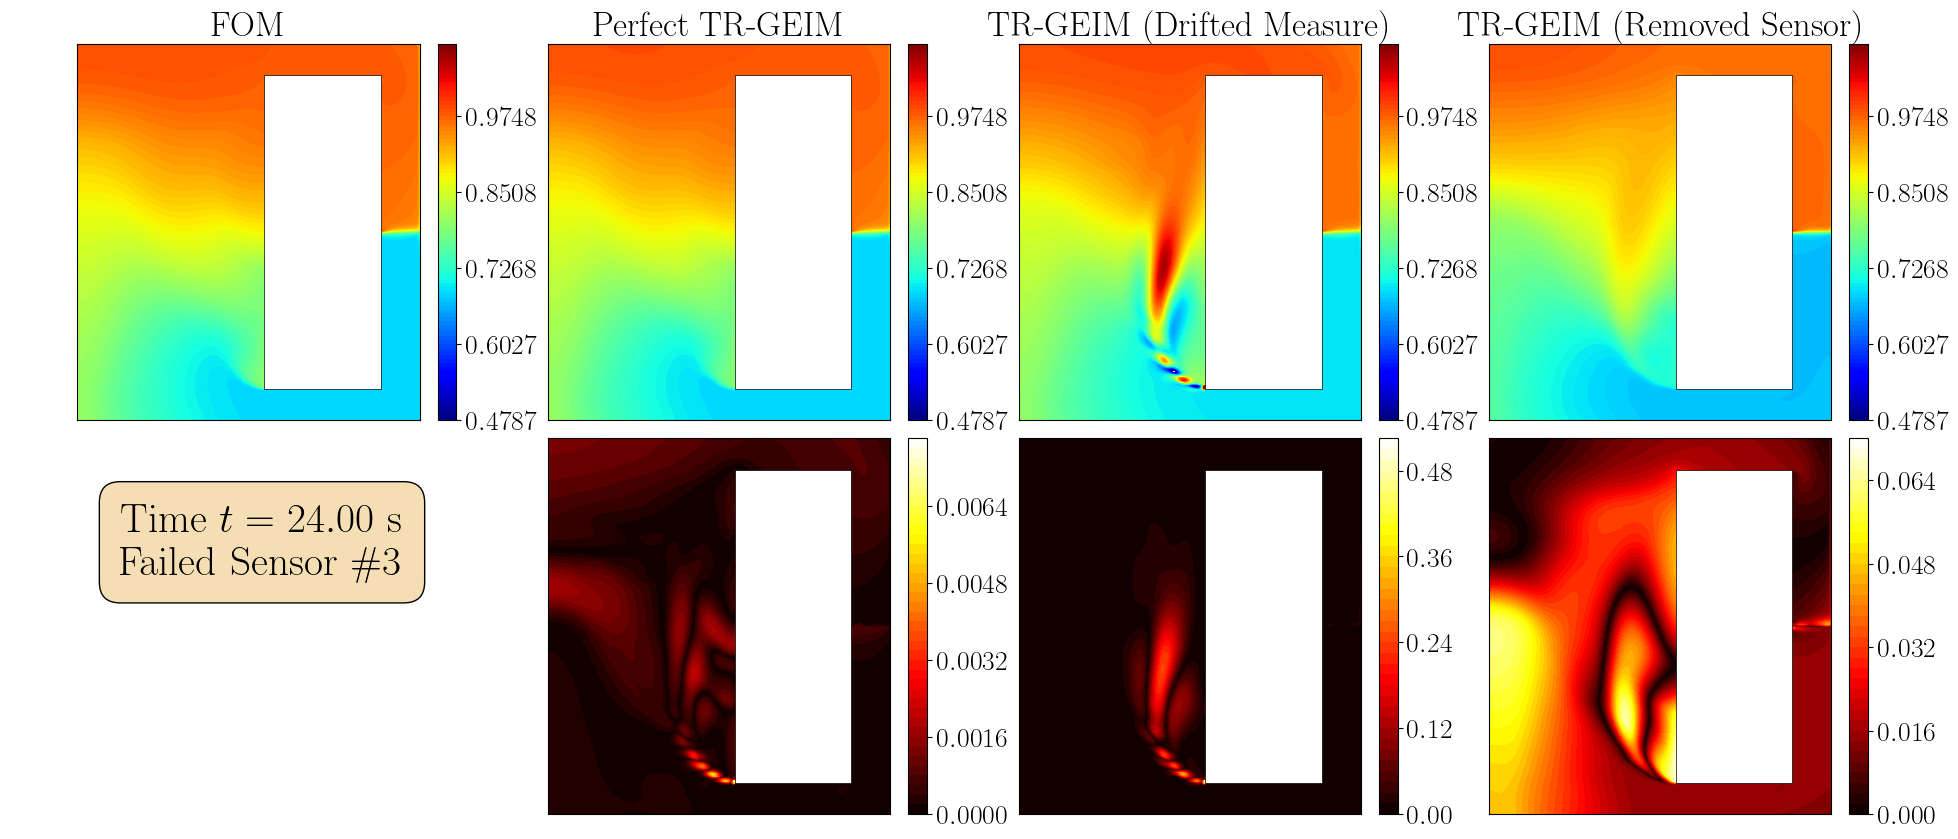

In [31]:
from utils import plot_contour

mesh_plot = np.concatenate((domain.geometry.x[:, 0].reshape(-1,1), domain.geometry.x[:, 2].reshape(-1,1)), axis=1)

cmap = cm.jet

tt = len(test_snaps[field]) - 40

_min = min([test_snaps[field](tt).min(),
           perfect_recons['TR-GEIM'](tt).min(),
            failure_recons['TR-GEIM'](tt).min(),
           remove_recons['TR-GEIM'](tt).min()])*1.1
_max = max([test_snaps[field](tt).max(),
           perfect_recons['TR-GEIM'](tt).max(),
            # failure_recons['TR-GEIM'](tt).max(),
           remove_recons['TR-GEIM'](tt).max()])*1.1

levels = np.linspace(_min, _max, 100)

fig, axs = plt.subplots(2,4, figsize=(6 * 4, 10))

# FOM and recons
cont = plot_contour(axs[0, 0], mesh_plot, test_snaps[field](tt), cmap=cmap, levels=levels, full_core=False)
plot_contour(axs[0, 1], mesh_plot, perfect_recons['TR-GEIM'](tt), cmap=cmap, levels=levels, full_core=False)
plot_contour(axs[0, 2], mesh_plot, failure_recons['TR-GEIM'](tt), cmap=cmap, levels=levels, full_core=False)
plot_contour(axs[0, 3], mesh_plot, remove_recons['TR-GEIM'](tt), cmap=cmap, levels=levels, full_core=False)

for ax in axs[0]:
    cbar = fig.colorbar(cont, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator.set_params(nbins=5)
    cbar.update_ticks()

# Residuals
axs[1,0].axis('off')
res_cont = plot_contour(axs[1, 1], mesh_plot, 
             np.abs(perfect_recons['TR-GEIM'](tt) - test_snaps[field](tt)), cmap= cm.hot, levels=40, full_core=False)
cbar = fig.colorbar(res_cont, ax=axs[1,1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.locator.set_params(nbins=5)
cbar.update_ticks()

res_cont = plot_contour(axs[1, 2], mesh_plot,
             np.abs(failure_recons['TR-GEIM'](tt) - test_snaps[field](tt)), cmap=cm.hot, levels=40, full_core=False)
cbar = fig.colorbar(res_cont, ax=axs[1,2], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.locator.set_params(nbins=5)
cbar.update_ticks()

res_cont = plot_contour(axs[1, 3], mesh_plot,
             np.abs(remove_recons['TR-GEIM'](tt) - test_snaps[field](tt)), cmap=cm.hot, levels=40, full_core=False)
cbar = fig.colorbar(res_cont, ax=axs[1,3], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.locator.set_params(nbins=5)
cbar.update_ticks()

fig.text(0.23, 0.35, f'Time $t={fom_times[test_indices[tt]]:.2f}$ s\nFailed Sensor \#{failed_sens_i[0]+1}', fontsize=30, ha='center',
         bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='round,pad=0.5'))

axs[0, 0].set_title('FOM', fontsize=25)
axs[0, 1].set_title('Perfect TR-GEIM', fontsize=25)
axs[0, 2].set_title('TR-GEIM (Drifted Measure)', fontsize=25)
axs[0, 3].set_title('TR-GEIM (Removed Sensor)', fontsize=25)

fig.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('FailureTRGEIM_comparison.png', bbox_inches='tight', dpi=300)

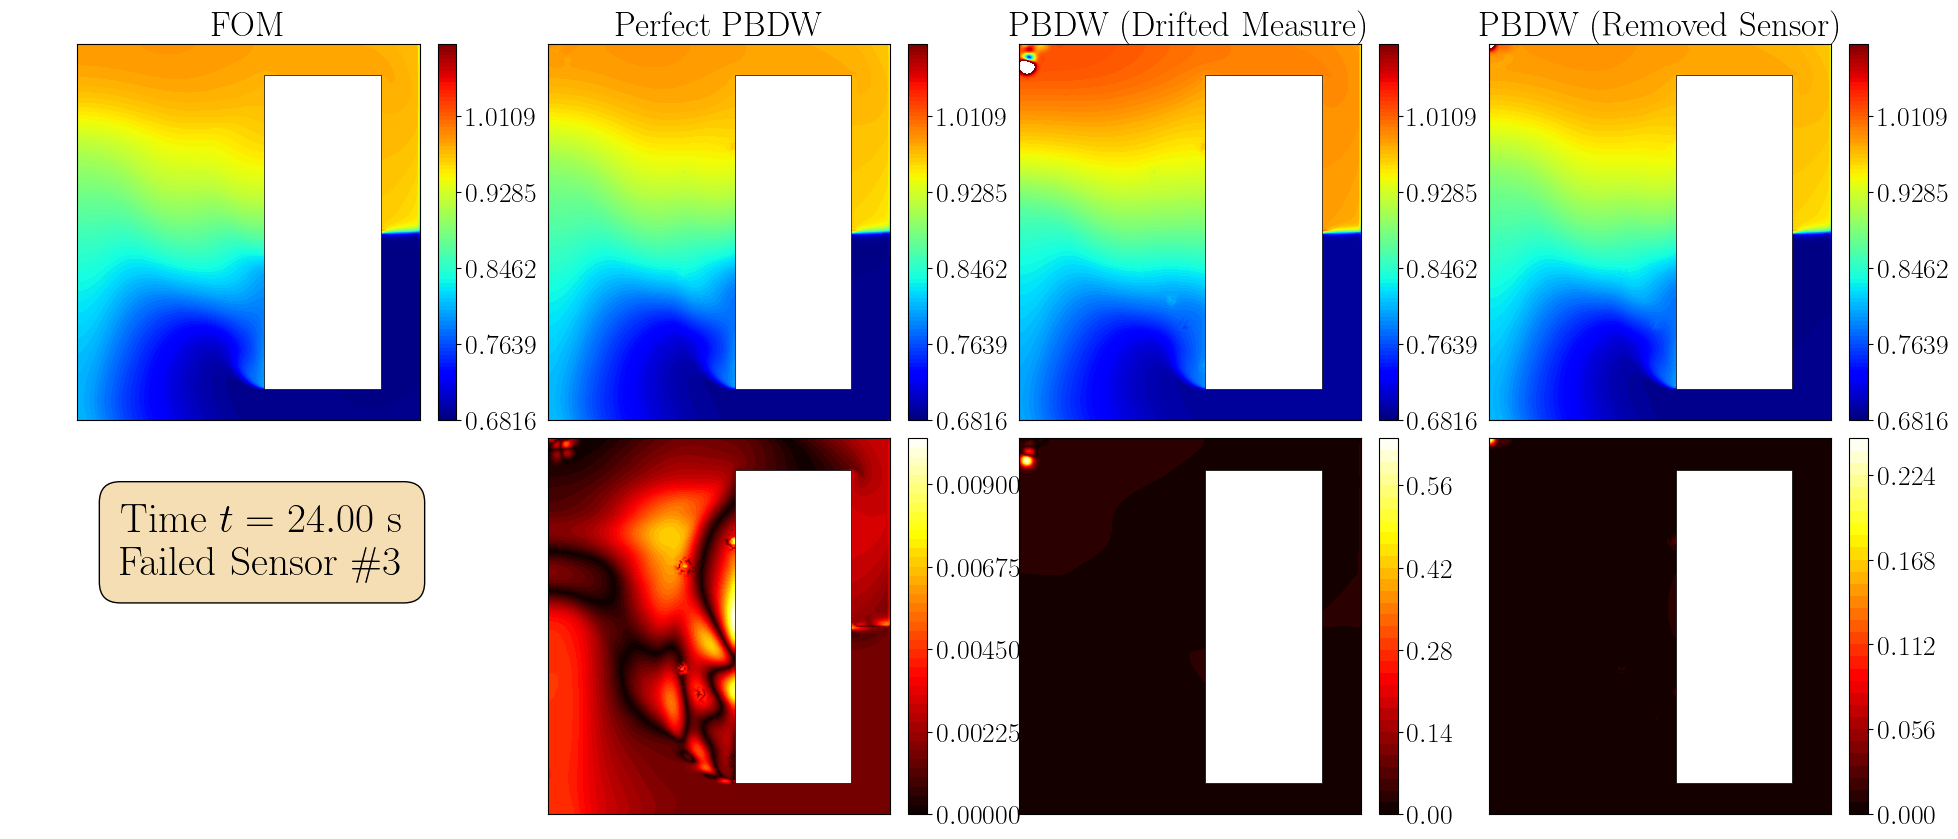

In [35]:
from utils import plot_contour

mesh_plot = np.concatenate((domain.geometry.x[:, 0].reshape(-1,1), domain.geometry.x[:, 2].reshape(-1,1)), axis=1)

cmap = cm.jet

tt = len(test_snaps[field]) - 40

_min = min([test_snaps[field](tt).min(),
           perfect_recons['PBDW'](tt).min(),
            failure_recons['PBDW'](tt).min(),
           remove_recons['PBDW'](tt).min()])
_max = max([test_snaps[field](tt).max(),
           perfect_recons['PBDW'](tt).max(),
            # failure_recons['PBDW'](tt).max(),
        #    remove_recons['PBDW'](tt).max()
           ]) * 1.1

levels = np.linspace(_min, _max, 100)

fig, axs = plt.subplots(2,4, figsize=(6 * 4, 10))

# FOM and recons
cont = plot_contour(axs[0, 0], mesh_plot, test_snaps[field](tt), cmap=cmap, levels=levels, full_core=False)
plot_contour(axs[0, 1], mesh_plot, perfect_recons['PBDW'](tt), cmap=cmap, levels=levels, full_core=False)
plot_contour(axs[0, 2], mesh_plot, failure_recons['PBDW'](tt), cmap=cmap, levels=levels, full_core=False)
plot_contour(axs[0, 3], mesh_plot, remove_recons['PBDW'](tt), cmap=cmap, levels=levels, full_core=False)

for ax in axs[0]:
    cbar = fig.colorbar(cont, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    cbar.locator.set_params(nbins=5)
    cbar.update_ticks()

# Residuals
axs[1,0].axis('off')
res_cont = plot_contour(axs[1, 1], mesh_plot, 
             np.abs(perfect_recons['PBDW'](tt) - test_snaps[field](tt)), cmap= cm.hot, levels=40, full_core=False)
cbar = fig.colorbar(res_cont, ax=axs[1,1], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.locator.set_params(nbins=5)
cbar.update_ticks()

res_cont = plot_contour(axs[1, 2], mesh_plot,
             np.abs(failure_recons['PBDW'](tt) - test_snaps[field](tt)), cmap=cm.hot, levels=40, full_core=False)
cbar = fig.colorbar(res_cont, ax=axs[1,2], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.locator.set_params(nbins=5)
cbar.update_ticks()

res_cont = plot_contour(axs[1, 3], mesh_plot,
             np.abs(remove_recons['PBDW'](tt) - test_snaps[field](tt)), cmap=cm.hot, levels=40, full_core=False)
cbar = fig.colorbar(res_cont, ax=axs[1,3], orientation='vertical', fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar.locator.set_params(nbins=5)
cbar.update_ticks()

fig.text(0.23, 0.35, f'Time $t={fom_times[test_indices[tt]]:.2f}$ s\nFailed Sensor \#{failed_sens_i[0]+1}', fontsize=30, ha='center',
         bbox=dict(facecolor='wheat', edgecolor='black', boxstyle='round,pad=0.5'))

axs[0, 0].set_title('FOM', fontsize=25)
axs[0, 1].set_title('Perfect PBDW', fontsize=25)
axs[0, 2].set_title('PBDW (Drifted Measure)', fontsize=25)
axs[0, 3].set_title('PBDW (Removed Sensor)', fontsize=25)

fig.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('FailurePBDW_comparison.png', bbox_inches='tight', dpi=300)

## Comparing the errors with removed sensors

In [41]:
errors_remove = {
    'TR-GEIM': np.zeros((M, 2)),
    'PBDW': np.zeros((M, 2))
}

for failed_sens_i in range(0, M):

    print(f'Failed Sensor #{failed_sens_i+1}')

    errors_remove['TR-GEIM'][failed_sens_i] = failing_trgeim.pure_remove_test_err(test_snaps[field], M=M,
                                                                noise_value=noise_level, reg_param=noise_level**2,
                                                                idx_failed=[failed_sens_i], verbose=False)[0].mean(axis=0)
    
    errors_remove['PBDW'][failed_sens_i] = failing_pbdw.pure_remove_test_err(test_snaps[field], N=N, M=M,
                                                                noise_value=noise_level, reg_param=10 * np.ones(M),
                                                                idx_failed=[failed_sens_i], verbose=False)[0].mean(axis=0)

Failed Sensor #1
Failed Sensor #2
Failed Sensor #3
Failed Sensor #4
Failed Sensor #5
Failed Sensor #6
Failed Sensor #7
Failed Sensor #8
Failed Sensor #9
Failed Sensor #10
Failed Sensor #11
Failed Sensor #12
Failed Sensor #13
Failed Sensor #14
Failed Sensor #15


Let us compare the errors of the TR-GEIM and PBDW methods with perfect case

In [ ]:
errors_perfect = dict()

errors_perfect['TRGEIM'] = perfect_trgeim.synt_test_error(test_snaps[field], M=M, noise_value=noise_level, reg_param=noise_level**2, verbose=True)[1]

errors_perfect['PBDW'] = perfect_pbdw.synt_test_error(test_snaps[field], N=N, M=M, noise_value=noise_level, reg_param=10, verbose=True)[1]

In [46]:

errors_perfect['PBDW'] = perfect_pbdw.synt_test_error(test_snaps[field], N=N, M=M, noise_value=noise_level, reg_param=10, verbose=True)[1]

Computing PBDW test error (synthetic) with N = 5 - T: 69.000 / 69.00 - 0.288 s/it


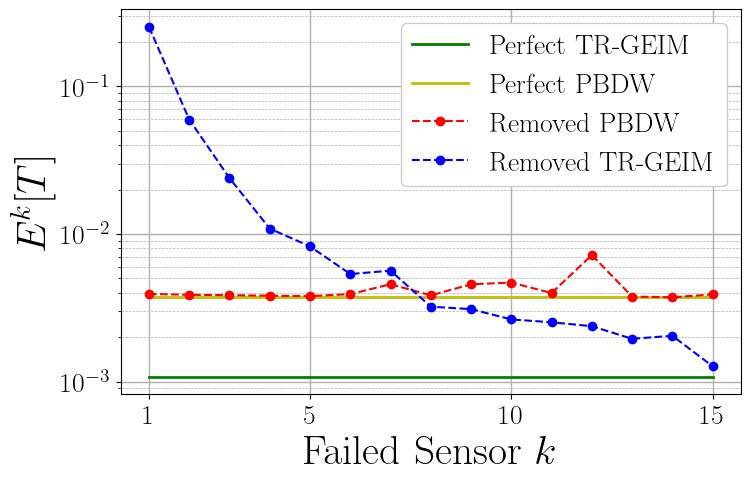

In [63]:
fig = plt.figure(figsize=(8,5))

Mplot = np.arange(1, M+1)
plt.semilogy(Mplot, errors_perfect['TRGEIM'][-1] * np.ones(M), 'g-', label='Perfect TR-GEIM', linewidth=2)
plt.plot(Mplot, errors_perfect['PBDW'][-1] * np.ones(M), 'y-', label='Perfect PBDW', linewidth=2)

plt.plot(Mplot, errors_remove['PBDW'][:,1], 'ro--', label='Removed PBDW')
plt.plot(Mplot, errors_remove['TR-GEIM'][:,1], 'bo--', label='Removed TR-GEIM')

plt.grid(which='minor', linestyle='--', linewidth=0.5)
plt.grid(which='major', linestyle='-', linewidth=1)

plt.xlabel('Failed Sensor $k$', fontsize=30)
plt.ylabel(r'$E^k[T]$', fontsize=30)


plt.xticks([1,5,10,15], fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20, loc='upper right', framealpha=1)
plt.savefig('pure_remove_errorPlot_comparison.pdf', bbox_inches='tight', dpi=300)